# Approximate Bayesian Computation

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, norm, poisson, uniform, halfnorm, truncnorm
from corner import corner 
import elfi # python -m pip install elfi
import networkx as nx
sns.set_context('talk')

red, blue, green = sns.color_palette('Set1', 3)

def traceplot(samples, var_names, real_vars):
    nrows = len(var_names)
    fig, axes = plt.subplots(nrows, 1, figsize=(3*nrows, 6))

    for sample, var_name, param, ax in zip(samples, var_names, real_vars, axes.flat):
        ax.plot(sample, color='k', alpha=0.75)
        ax.axhline(sample.mean(), color=green)
        ax.axhline(param, color=red)
        ax.set_ylabel(var_name)

    fig.tight_layout()
    sns.despine()

# Bayesian inference

*Reminder:* Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. 

**Bayes' theorem**.
Consider the events $A$ and $B$, then Bayes' theorem states that

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Applied to model-based inference, we define:
- $\theta$ are the model parameters
- $X$ are the data
and we have
$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)}
$$
where
- $P(\theta)$ is called the *prior probability* that formulates our beliefs about the model before seeing any data
- $P(X \mid \theta)$ is the probability of observing $X$ given $\theta$, what we called the *likelihood of $\theta$*
- $P(\theta \mid X)$ is called the *posterior probability*, that is, how our beliefs about the model changed due to observing the data
- $P(X)$ is the probability of observing the data unconditioned on the model; we usually ignore it as it does not depend on the model

In Bayesian inference we attempt to estimate the posterior distribution over the model parameters; this constrast with classical/frequentist approaches like *maximum likelihood* in which we attempt to estimate a point estimate of the parameters - a single parameter value.

But what happens if we cannot write or even compute the likelihood function $P(X \mid \theta)$?

The family of methods that try to resolve this problem are called **likelihood free inference** methods, and the most common one is approximate Bayesian computation, or ABC.

# Approximate Bayesian computation

ABC is a likelihood-free method of Bayesian inference that uses simulation to approximate the posterior distribution of the model parameters. 
It is used where
- the likelihood function is unknown or is too computationally expensive to compute, and
- there exists a good _forward model_ that can produce data sets like the one of interest.

It is not a replacement for other methods when a likelihood function is available (depsite the example we use in this lecture)!

**Reminder:** in MCMC sampling used in Bayesian inference when the likelihood is known, the algorithm follows these steps:

At iteration $i$, given the previous parameter value $\theta_i$, we
1. Generate a candidate parameter value $\theta^*$ from a proposal distribution $\theta^* \sim N(\theta_i, \eta)$.
1. Compute the likelihood $P(X \mid \theta^*)$.
1. Set the acceptance probability $\alpha = \frac{P(\theta^* \mid X)}{P(\theta_i \mid X)} = \frac{P(X \mid \theta^*)P(\theta^*)}{P(X \mid \theta_i)P(\theta_i)}$ to the ratio of posterior probabilities.
1. Set $\theta_{i+1} = \theta^*$ with probability $min(1,\alpha)$ (i.e. accept $\theta^*$), otherwise set $\theta_{i+1} = \theta_i$ (i.e. reject $\theta^*$ and keep $\theta_i$ again).

In ABC, we cannot compute the likelihood $P(X \mid \theta)$.
But, we can sample from the distribution that this likelihood represents using a simulator: $f(X) \sim P(X \mid \theta)$.

We can then compare the simulated $X'$ and the observed $X$ to conclude if $\theta$ is likely -- thereby approximating the likelihood of $\theta$ without directly computing it.

![ABC](../resources/ABC.png)
from [Cranmer et al, 2019](http://arxiv.org/abs/1911.01429)

What do we need for ABC?

- we need a simulator $f(\theta)$ that samples from a distribution that approximates the likelihood function, that is $P(f(\theta)=X) P(X \mid \theta)$.
- we need a good way (???) to summarize the data $S(X)$,
- we need a good way (???) to measure the distance between two summaries $\rho(S(X'), S(X))$, and
- we need a good way (???) to decide if the measured distance is small enough to accept the parameters that generated it.

# Photon count model

We use the "complex" photon count model that we have seen before.

the measurements $\{X_i\}$ are still drawn from a Poisson distribution, but the expectation ($F_i$) changes over time -- it is drawn from a normal distrubtion with expectation $\mu$ and standard deviation $\sigma$:
$$
F_i \sim N(\mu, \sigma) \\
X_i \sim Poi(F_i)
$$

We note the model parameters as $\theta = (\mu, \sigma)$.

In [2]:
# for reproducibility
np.random.seed(42)
batch_size = 100  
θ = (μ, σ) = 1000, 15
F = norm(μ, σ).rvs(size=batch_size)
X = poisson(F).rvs()

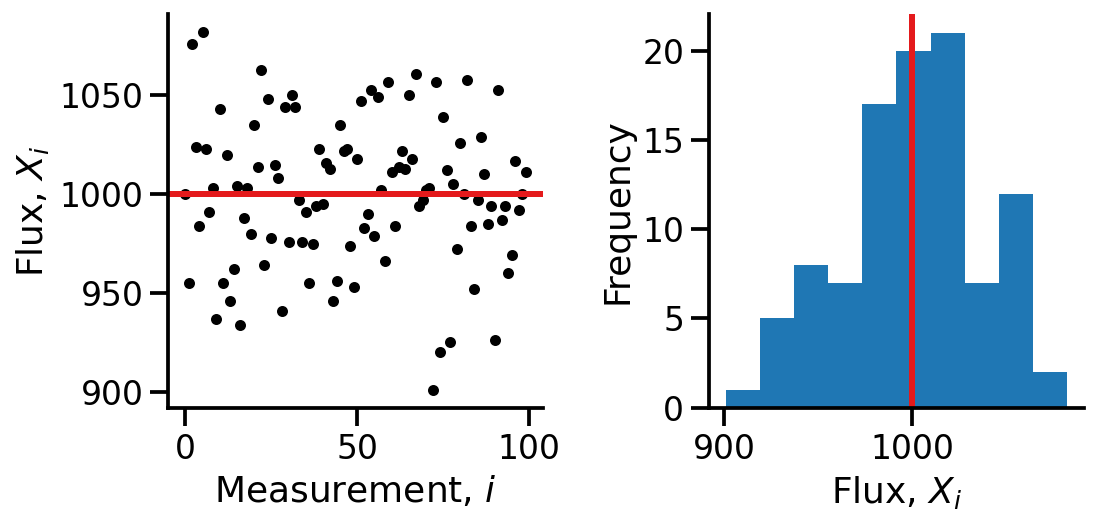

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(batch_size), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Flux, $X_i$")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux, $X_i$")

fig.tight_layout()
sns.despine()

# Rejection sampling with NumPy

Given empirical data $X$, a model parameterized by the vector $\theta$, and a simulation $f(\theta)$ that implements the model and generates simulated data $X'$, the following describes the *rejection sampling algorithm*:

1. Generate candidate parameter value from the prior $\theta^* \sim P(\theta)$  
1. Generate data from the simulation $X^* = f(\theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(X^*), S(X))$
1. Accept $\theta^*$ if $\rho^* \le \epsilon$.

The collection of accepted $\theta^*$ values approximates the posterior distribution $P(\theta \mid X)$; the smaller $\epsilon$ is, the better the approximation.

How do we set $\epsilon$?
In this case, we looked at the plot to get some intuition. 
If we don't have an intuition, we can take the best 1% or 5% of samples.
The problem is that the acceptance rate can be very low.
We'll deal with that in the next section.

We will use a weak prior:
$$
\mu \sim \mathit{Normal}(990, 10) \\
\sigma \sim \mathit{HalfNormal}(\mu=0, \sigma=50)
$$

We also use a half-normal distribution for $\sigma$ (see [Gelman 2006](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf) for a discussion about priors for variance parameters).


In [4]:
N = 10000

μ_prior = norm(990, 10)
σ_prior = halfnorm(0, 50)
μs = μ_prior.rvs(size=N)
σs = σ_prior.rvs(size=N)

def log_prior(μ, σ):
    return (μ_prior.logpdf(μ) + σ_prior.logpdf(σ)).sum()

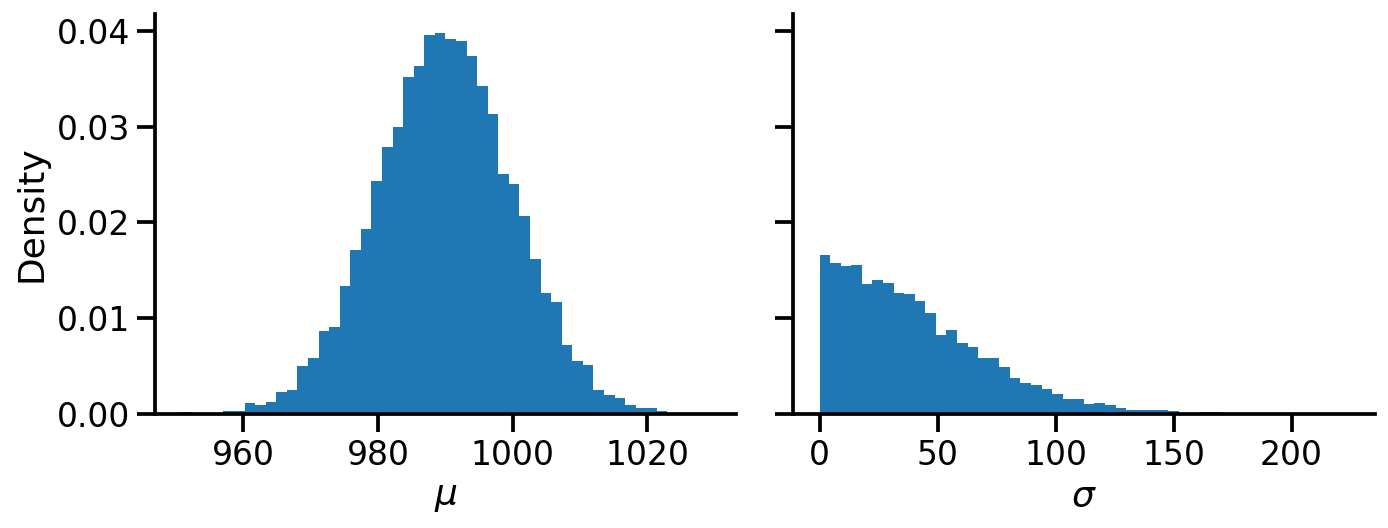

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(μs, bins=50, density=True)
axes[1].hist(σs, bins=50, density=True)
axes[0].set(xlabel='$\mu$', ylabel='Density')
axes[1].set(xlabel='$\sigma$')
fig.tight_layout()
sns.despine()

We need a simulator, a summary, and a distance.

For summaries, we will use the mean and standard deviation.

$$
S_1(X) = \frac{1}{n}\sum_{i=1}^{n}{X_i} \\
S_2(X) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(X_i - S_1(X))^2}} \\
$$

The distance function will be the absolute distance:
$$
\rho(X', X) = \big|S_1(X')-S_1(X)\big| + \big|S_2(X')-S_2(X)\big|
$$

Note that these functions expect a 2D array with shape `(experiments, samples)`; the idea is to use NumPy array operations to compute many simulations, summaries, and distances together.

In [6]:
def simulator(μ, σ, batch_size=1, random_state=None):
    """μ, σ: parameters
       batch_size: number of simulations
       random_state: ignore
    """
    μ, σ = np.atleast_1d(μ, σ) # is scalar convert to 1d
    F = norm(μ, σ).rvs(size=(batch_size, μ.size)) 
    X_sim = poisson(np.maximum(F, 0)).rvs()
    return X_sim.T

def summary(X):
    X = np.atleast_2d(X)
    S1 = X.mean(axis=1)
    S2 = X.std(axis=1, ddof=1)
    return np.array([S1, S2]).T

def distance(S_sim, S):
    diff = S - S_sim
    absdiff = np.abs(diff)
    return absdiff.sum(axis=1) # sum over summaries

In [7]:
X_sim = simulator(μs, σs, batch_size)
assert X_sim.shape == (N, batch_size)
S = summary(X)
S_sim = summary(X_sim)
assert S_sim.shape == (N, 2), S_sim.shape
ρs = distance(S_sim, S)
assert ρs.shape == (N,)

We can take a look at what we got.

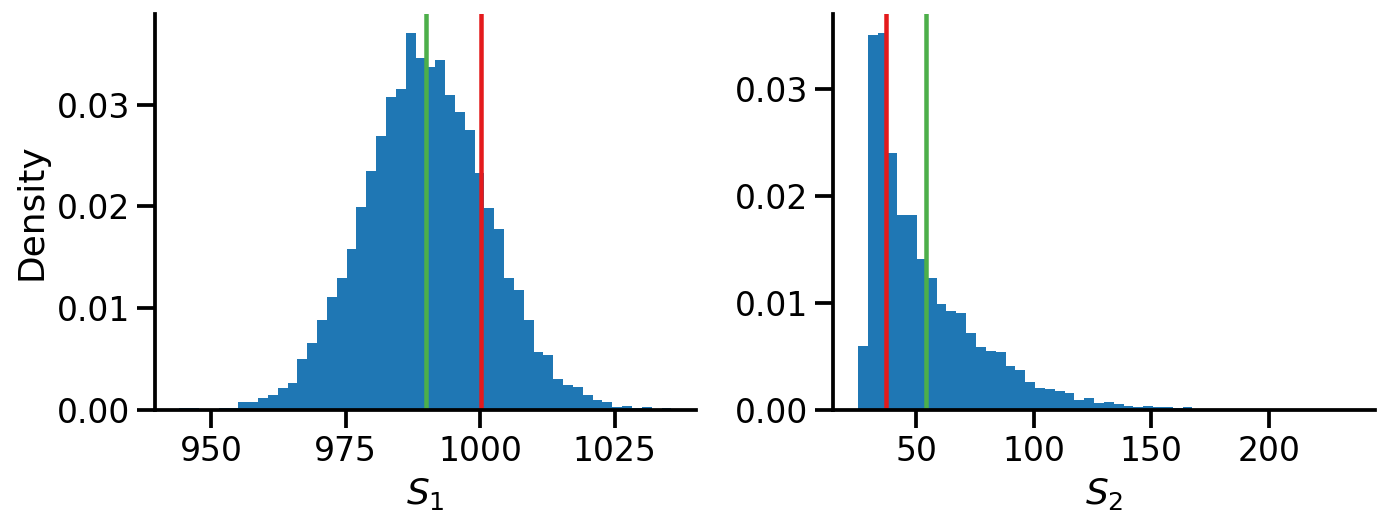

In [8]:
S1, S2 = S.T # S is shape (1,2)
S1_sim, S2_sim = S_sim.T # S_sim is shape (N,2)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.hist(S1_sim, bins=50, density=True)
ax.axvline(S1, color=red)
ax.axvline(S1_sim.mean(), color=green)
ax.set_xlabel(r"$S_1$")
ax.set_ylabel("Density")
ax = axes[1]
ax.hist(S2_sim, bins=50, density=True)
ax.axvline(S2, color=red)
ax.axvline(S2_sim.mean(), color=green)
ax.set_xlabel(r"$S_2$")
fig.tight_layout()
sns.despine()

As for the distances, lets look at the standardized distance (distance divided by the standard deviation).

The plot shows the distance function for all the simulations (blue and green).
The red line shows the real parameter values.
The black line shows the value $\epsilon$, which is a threshold that accepts 10% of the samples.

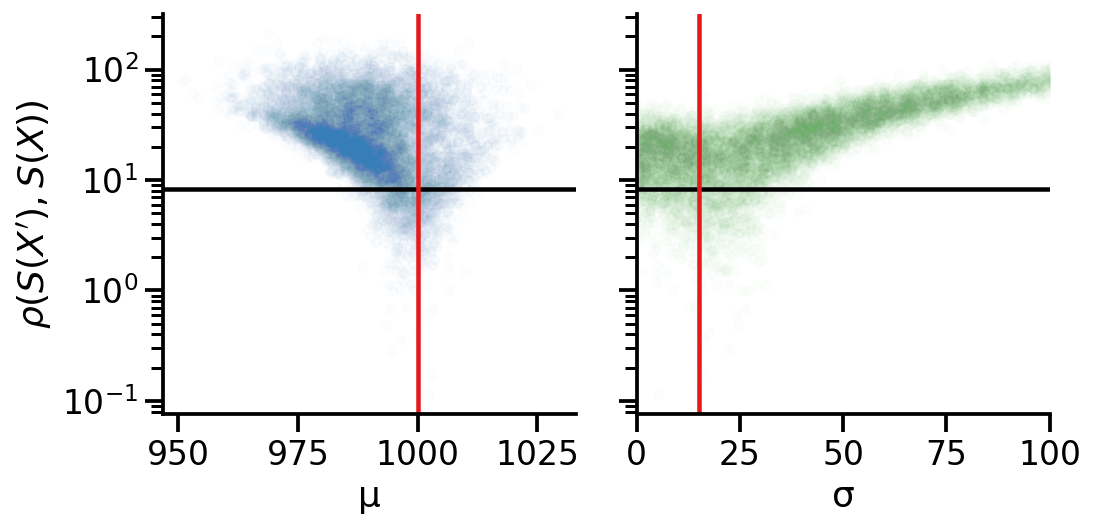

In [9]:
quantile = 0.1
ϵ = np.quantile(ρs, quantile)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plot_kws = dict(marker='.', ls='', alpha=0.01)
                  
ax = axes[0]
ax.plot(μs, ρs, color=blue, **plot_kws)
ax.axhline(ϵ, color='k')
ax.axvline(μ, color=red)
ax.set(xlabel='μ', yscale='log', ylabel=r"$\rho(S(X'), S(X))$")

ax = axes[1]
ax.plot(σs, ρs, color=green, **plot_kws)
ax.axhline(ϵ, color='k')
ax.axvline(σ, color=red)
ax.set(xlabel='σ', xlim=(0, 100))

fig.tight_layout()
sns.despine()

We now accept and reject.

In [10]:
idx_accepted = ρs < ϵ
print("Accepted {} ({:.2%}) of {} generated samples".format(
    idx_accepted.sum(), idx_accepted.mean(), idx_accepted.size))
μs_accepted = μs[idx_accepted]
σs_accepted = σs[idx_accepted]

Accepted 1000 (10.00%) of 10000 generated samples


We now treat the accepted parameter samples as an approximate to the posterior distribtion:

In [11]:
μ_hat, σ_hat = μs_accepted.mean(), σs_accepted.mean()

print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

μ = 1000 	μ_hat = 998.40
σ = 15		σ_hat = 16.24


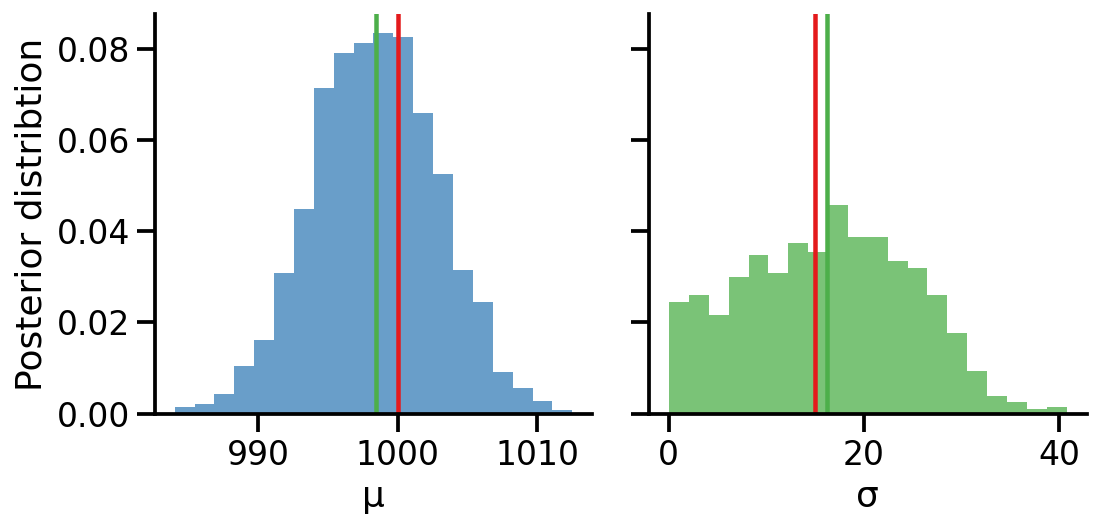

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
hist_kws = dict(bins=20, density=True, alpha=0.75)

ax = axes[0]
ax.hist(μs_accepted, color=blue, **hist_kws)
ax.axvline(μ, color=red)
ax.axvline(μs_accepted.mean(), color=green)
ax.set(xlabel='μ', ylabel='Posterior distribtion')

ax = axes[1]
ax.hist(σs_accepted, color=green, **hist_kws)
ax.axvline(σ, color=red)
ax.axvline(σs_accepted.mean(), color=green)
ax.set(xlabel='σ')

fig.tight_layout()
sns.despine()

The red and green lines are the real and point-estimates of the parameters.
Its OK, but not that good.

# Rejection sampling with elfi

We now use the [elfi](https://elfi.readthedocs.io/en/latest/usage/tutorial.html#sequential-monte-carlo-abc) package for likelihood-free inference.

In [13]:
μ_ = elfi.Prior(μ_prior)
σ_ = elfi.Prior(σ_prior)

sim = elfi.Simulator(simulator, μ_, σ_, observed=X)

S = elfi.Summary(summary, sim)
D = elfi.Distance(distance, S)

In [14]:
N_ = int(N * quantile) # draw same number of sample as the numpy version
rejection = elfi.Rejection(D, batch_size=batch_size)
rej_res = rejection.sample(N, threshold=ϵ)
rej_res.summary()

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: Rejection
Number of samples: 10000
Number of simulations: 98600
Threshold: 8.37
Sample means: μ_: 998, σ_: 16.4


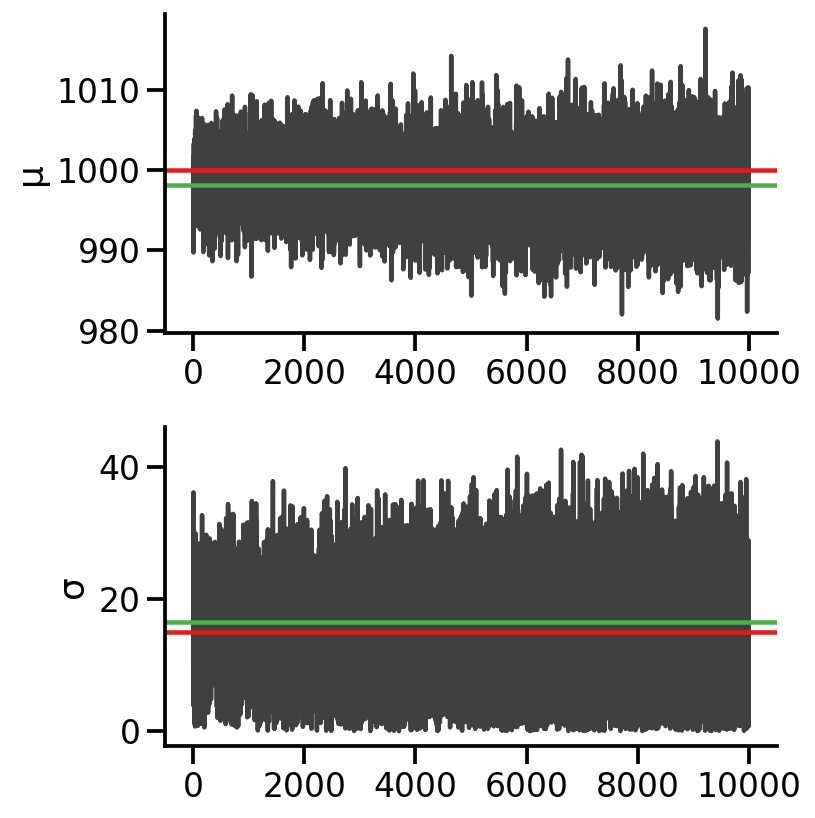

In [15]:
traceplot(rej_res.samples_array.T, ['μ', 'σ'], [μ, σ])

In [16]:
μ_sample, σ_sample = rej_res.samples_array.T
μ_hat, σ_hat = μ_sample.mean(), σ_sample.mean()

print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

μ = 1000 	μ_hat = 998.16
σ = 15		σ_hat = 16.43


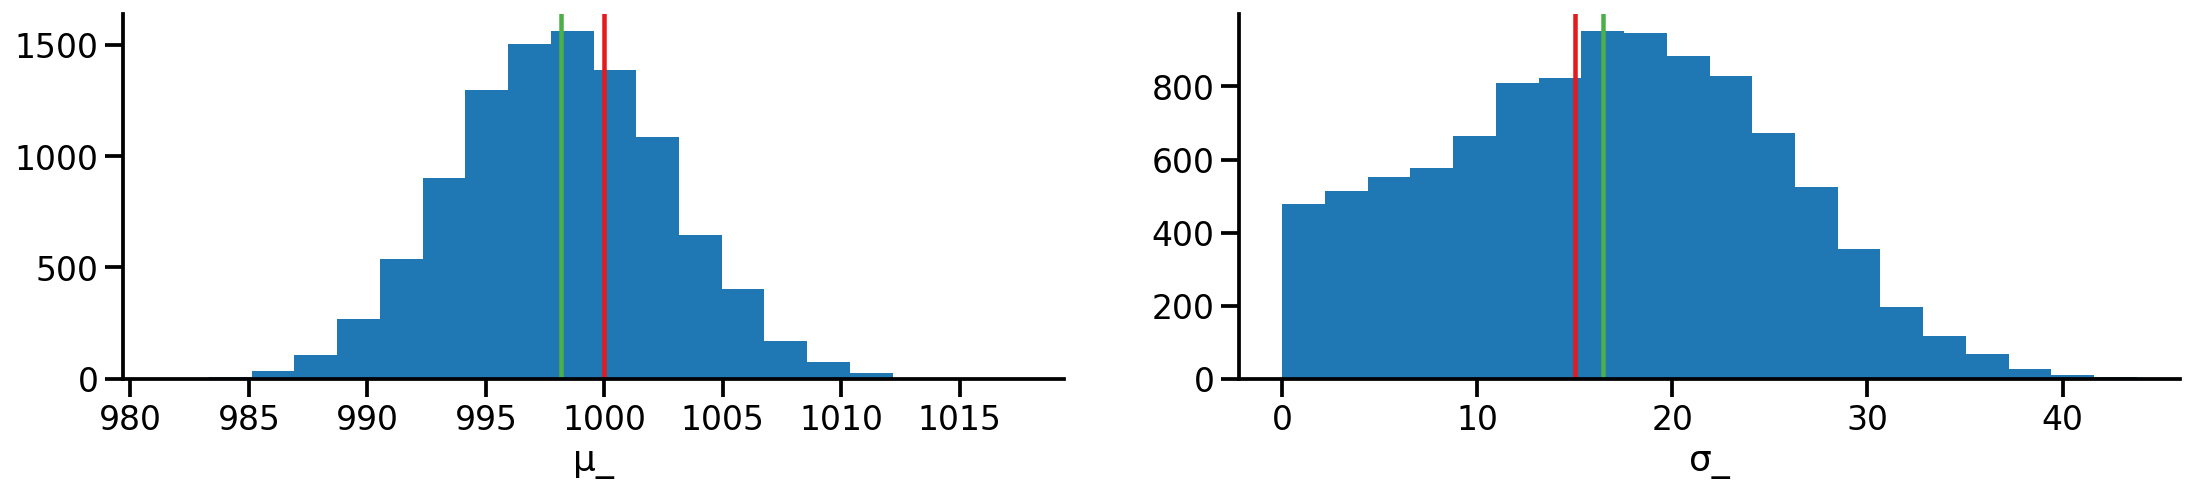

In [17]:
axes = rej_res.plot_marginals(['μ_', 'σ_'])
axes[0].axvline(μ, color=red)
axes[1].axvline(σ, color=red)
axes[0].axvline(μ_hat, color=green)
axes[1].axvline(σ_hat, color=green)
sns.despine()

# MCMC sampling

A common sampler that deals with the inefficiency of the rejection sampler is the Markov chain Monte Carlo (MCMC) sampler, which creates chains of accepted parameter samples of length $N$ using the algorithm:

1. Initiaize $\theta_1$, $i=1$.
1. Generate a candidate parameter value $\theta^* \sim q(\theta \mid \theta_i) = N(\theta_i, \eta)$.
1. Generate data from the simulator $X^* = f(\theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(X^*), S(X))$ using the summary $S(X)$.
1. If $\rho^* \le \epsilon$, set the acceptance probability $\alpha=\min{\Big(1, \frac{P(\theta^*)}{P(\theta_i)}\Big)}$. 
1. Otherwise set it to $\alpha=0$.
1. Accept $\theta_{i+1}=\theta^*$ with probability $\alpha$ and $\theta_{i+1}=\theta_i$ with probability $(1-\alpha)$.
1. If $i<N$, increment $i = i + 1$ and go to step 2.

This sampling algorithm is much more efficient than the rejection sampling, as it is able to "spend more time" in areas of high likelihood.

However, this algorithm can get stuck on areas of low likelihood.

In the simulation step, it is possible to simulate multiple simulations and summarize all of them. This will leverage NumPy array operations for increased efficiency and precision.

# Sequential Monte Carlo sampling with elfi

Elfi implements a sequential Monte Carlo sampler (SMC).
This sampler has several advantages -- an adaptive acceptance rate ($\epsilon$), independent sampling of parameters, computational efficiency, and more.
For details on the SMC sampler in ABC and a comparison to rejection and MCMC sampling, see [the paper](http://doi.org/10.1073/pnas.0607208104):

> Sisson SA, Fan Y, Tanaka MM (2007) Sequential Monte Carlo without likelihoods. Proc Natl Acad Sci 104(6):1760–1765.

In [18]:
smc = elfi.SMC(D, batch_size=batch_size)
ϵs = np.quantile(rej_res.discrepancies, [0.5, 0.15, 0.05])
smc_res = smc.sample(N_, thresholds=ϵs)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [19]:
smc_res.summary(all=True)

Method: SMC
Number of samples: 1000
Number of simulations: 77600
Threshold: 1.82
Sample means: μ_: 999, σ_: 17.9

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 18200
Threshold: 5.82
Sample means: μ_: 999, σ_: 16.7

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 15700
Threshold: 3.17
Sample means: μ_: 999, σ_: 17

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 43700
Threshold: 1.82
Sample means: μ_: 999, σ_: 17.9


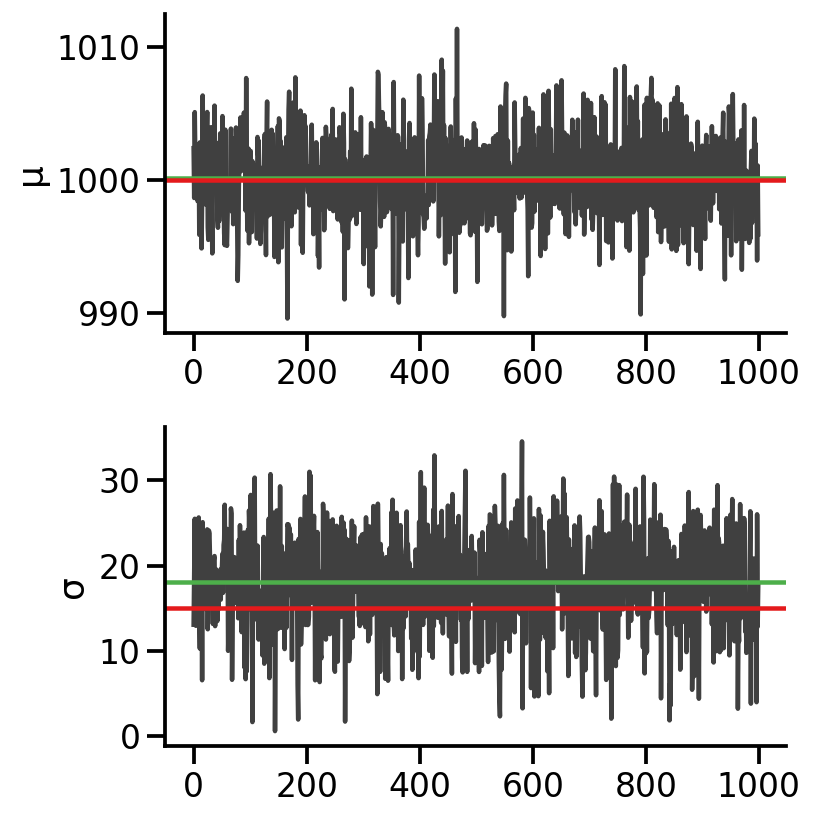

In [22]:
traceplot(smc_res.samples_array.T, ['μ', 'σ'], [μ, σ])

In [23]:
μ_sample = smc_res.samples['μ_']
σ_sample = smc_res.samples['σ_']
μ_hat, σ_hat = μ_sample.mean(), σ_sample.mean()

print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

μ = 1000 	μ_hat = 1000.14
σ = 15		σ_hat = 18.04


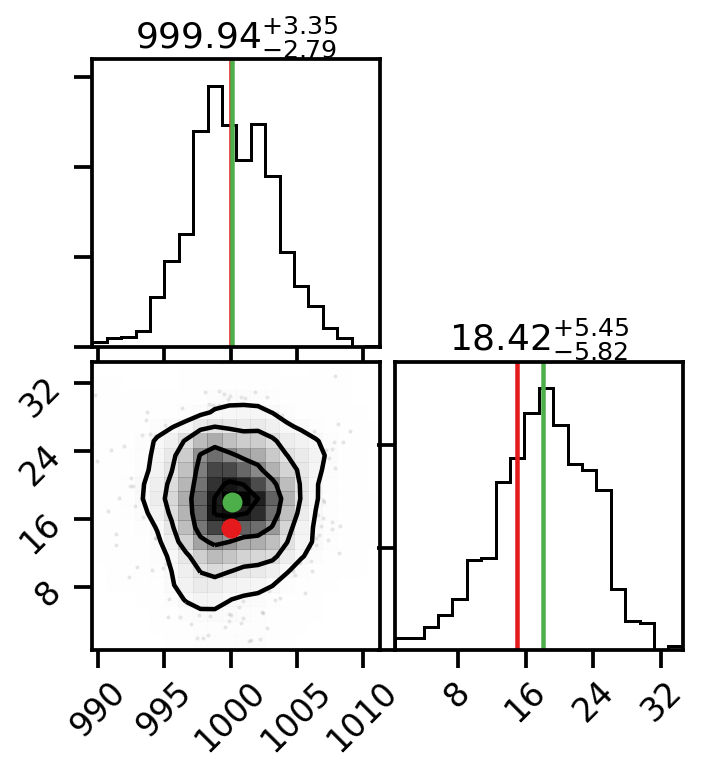

In [24]:
samples = np.array([μ_sample, σ_sample]).T
cor = corner(samples, 
    smooth=True,
    show_titles=True,
)
cor.axes[0].axvline(μ, color=red)
cor.axes[3].axvline(σ, color=red)
cor.axes[2].plot(μ, σ, 'o', color=red);
cor.axes[0].axvline(μ_hat, color=green)
cor.axes[3].axvline(σ_hat, color=green)
cor.axes[2].plot(μ_hat, σ_hat, 'o', color=green);

# Dolphins social network model

We follow the analysis from a [paper on animal social networks](https://www.nature.com/articles/ncomms12084)
> Ilany A, Akçay E (2016) Social inheritance can explain the structure of animal social networks. Nat Commun 7(May). doi:10.1038/ncomms12084.

To work with graphs and networks we use [NetworkX](https://networkx.github.io), and we require at least version 2.

In [25]:
# this requires networkx 2, but elfi needs networkx 1.11
# def show_net(network):
#     G = nx.from_numpy_array(network)
#     nx.draw_spring(G, node_color='#4466ee', alpha=0.8)

We download the dolphins data from [KONECT](http://konect.uni-koblenz.de/networks/dolphins); this site has a bunch of network data.

Now load the data and convert it to NumPy adjacency matrix.

In [26]:
dolphin_data = np.loadtxt('../data/dolphins/out.dolphins', comments='%', dtype=int)
dolphin_data[:5]

array([[ 9,  4],
       [10,  6],
       [10,  7],
       [11,  1],
       [11,  3]])

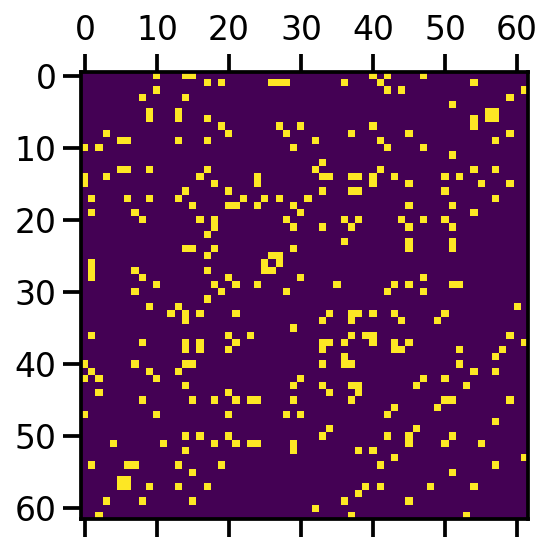

In [27]:
N = dolphin_data.max() # dolphin ids go from 1 to 62
dolphin_network = np.zeros((N, N), dtype=int)
for row in dolphin_data:
    src, dst = row
    # to zero count
    src -= 1
    dst -= 1
    # set connection
    dolphin_network[dst, src] = 1
    dolphin_network[src, dst] = 1
plt.matshow(dolphin_network)
dolphin_network = dolphin_network.ravel()

## Model and simulation

We model the development of a dolphin social network as in section _Simulation process_ of the paper by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084).

For the initial networks, use the [Erdos-Renyi random network generator](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html); [read more on these random graphs](https://en.wikipedia.org/wiki/Erdős–Rényi_model).

In [28]:
def simulator(pn, pr, batch_size=1, random_state=None):
    pn, pr = np.atleast_1d(pn), np.atleast_1d(pr)
    if pn.size < batch_size:
        pn = np.repeat(pn, batch_size)
    if pr.size < batch_size:
        pr = np.repeat(pr, batch_size)
        
    tmax = 20 * N
    deaths = np.random.randint(0, N, size=(batch_size, tmax))
    parents = np.random.randint(0, N, size=(batch_size, tmax))
    randoms = np.random.random(size=(batch_size, tmax, N))

    G = nx.erdos_renyi_graph(N, p=0.1/2)
    # network = nx.to_networkx_graphto_numpy_array(G, dtype=int) # only in networkx 2
    network = nx.to_pandas_dataframe(G).values # for networkx 1.11
    network = network.reshape((1, N, N)).astype(bool)
    network = np.repeat(network, batch_size, axis=0)
    
    for i in range(batch_size):

        for t in range(tmax):
            d = deaths[i, t]
            b = parents[i, t]
            network[i, d, :] = False
            network[i, :, d] = False
            moms_friends = network[i, b, :]
            rand = randoms[i, t, :]
            from_mom = moms_friends & (rand < pn[i])
            from_random = ~moms_friends & (rand < pr[i])
            network[i, d, :] = from_mom | from_random 
            network[i, d, b] = True
            network[i, :, d] = network[i, d, :]

    return network.reshape((batch_size, -1))

## Summaries

We calculate the summary statistics, which are the mean degree of network nodes, and the clustering coefficient. 
- Degree of a node is the number of edges connected to it.
- Clustering coefficient of a node is the fraction of possible triangles through that node that exist, that is $\frac{2 T(u)}{deg(u)(deg(u)-1)}$, where $T(u)$ is the number of triangles passing through the node and $deg(u)$ is the node degree.

In [29]:
def mean_degree(networks):
    networks = np.atleast_2d(networks)
    networks = networks.reshape((-1, N, N))
    sums = networks.sum(axis=1)
    return sums.mean(axis=1)

def clustering_coefficient(networks):
    networks = np.atleast_2d(networks)
    networks = networks.reshape((-1, N, N))
    G = (nx.from_numpy_matrix(net) for net in networks)
    clustering = [np.fromiter(nx.algorithms.clustering(G_).values(), dtype=float)
                  for G_ in G]
    clustering = np.array(clustering)
    return clustering.mean(axis=1)

In [30]:
print("Mean degree {:.2f} \nClustering coefficient {:.2f}".format(
    mean_degree(dolphin_network).squeeze(),
    clustering_coefficient(dolphin_network).squeeze()
))

Mean degree 5.13 
Clustering coefficient 0.26


We can compare this to simulation results by choosing values for $p_n$ and $p_r$.
We set  and simulate a network.

In [96]:
pn = 0.5
pr = 0.028
network = simulator(pn, pr, 50)
# show_net(network)
print("Mean degree {:.2f} \nClustering coefficient {:.2f}".format(
    mean_degree(network).mean(), 
    clustering_coefficient(network).mean()
)) 

Mean degree 4.95 
Clustering coefficient 0.29


## Inference with elfi

Now we'll use ABC to estimate the model parameters $p_n$ and $p_r$, and see if it finds estimates that are close to those from the paper.


We set an uninformative prior $U(0,1)$ on both $p_n$ and $p_r$.
Otherwise we follow the same steps as above.

In [32]:
elfi.new_model()
elfi.set_client('multiprocessing') # https://elfi.readthedocs.io/en/latest/usage/parallelization.html

In [33]:
pn_ = elfi.Prior('uniform', 0, 1)
pr_ = elfi.Prior('uniform', 0, 1)

In [34]:
sim = elfi.Simulator(simulator, pn_, pr_, observed=dolphin_network)

S1 = elfi.Summary(mean_degree, sim)
S2 = elfi.Summary(clustering_coefficient, sim)
D = elfi.Distance("cityblock", S1, S2)

We use the rejection sampler to get a feeling for the distances $\rho$.

In [35]:
rejection = elfi.Rejection(D, batch_size=20)
rej_res = rejection.sample(100, quantile=0.1)
rej_res.summary()

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: Rejection
Number of samples: 100
Number of simulations: 1000
Threshold: 4.16
Sample means: pn_: 0.296, pr_: 0.0546


Now we can run the SMC sampler. This will take some time.

In [37]:
pool = elfi.OutputPool(['pn', 'pr', 'S1', 'S2'])

In [38]:
smc = elfi.SMC(D, batch_size=50, pool=pool)
ϵs = np.quantile(rej_res.discrepancies, np.linspace(1, 0.01, 15))
smc_res = smc.sample(100, thresholds=ϵs)

In [180]:
pool.save()

In [181]:
smc_res.summary(all=True)

Method: SMC
Number of samples: 100
Number of simulations: 12550
Threshold: 0.154
Sample means: pn_: 0.389, pr_: 0.0399

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 1650
Threshold: 4.12
Sample means: pn_: 0.296, pr_: 0.059

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 200
Threshold: 2.99
Sample means: pn_: 0.323, pr_: 0.0524

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 200
Threshold: 3.21
Sample means: pn_: 0.318, pr_: 0.0511

Population 3:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 200
Threshold: 2.75
Sample means: pn_: 0.339, pr_: 0.0436

Population 4:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 200
Threshold: 2.53
Sample means: pn_: 0.31, pr_: 0.0493

Population 5:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 200
Threshold: 2.44
Sample m

In [188]:
pn_sample, pr_sample = smc_res.samples_array.T
pn_hat, pr_hat = pn_sample.mean(), pr_sample.mean()

print("pn_hat = {:.3f}\npr_hat = {:.3f}".format(pn_hat, pr_hat))

pn_hat = 0.381
pr_hat = 0.041


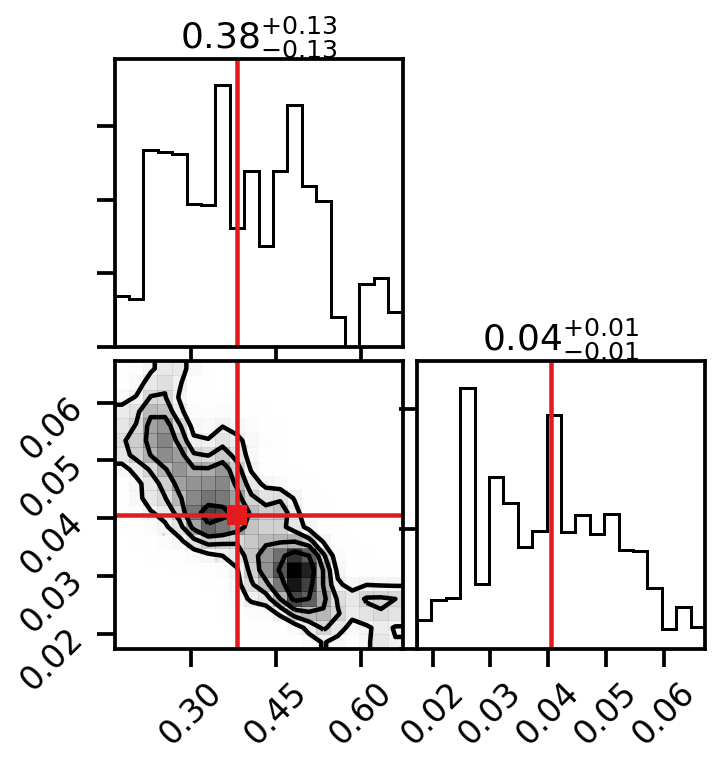

In [189]:
cor = corner(smc_res.samples_array, weights=smc_res.weights,
    smooth=True,
    show_titles=True,
    truths=[pn_hat, pr_hat],
    truth_color=red
);

Here the red mark are the estimates from the original paper, so we find very similar results to those found in the original paper.

How do the samples evolve from one SMC population to the next?

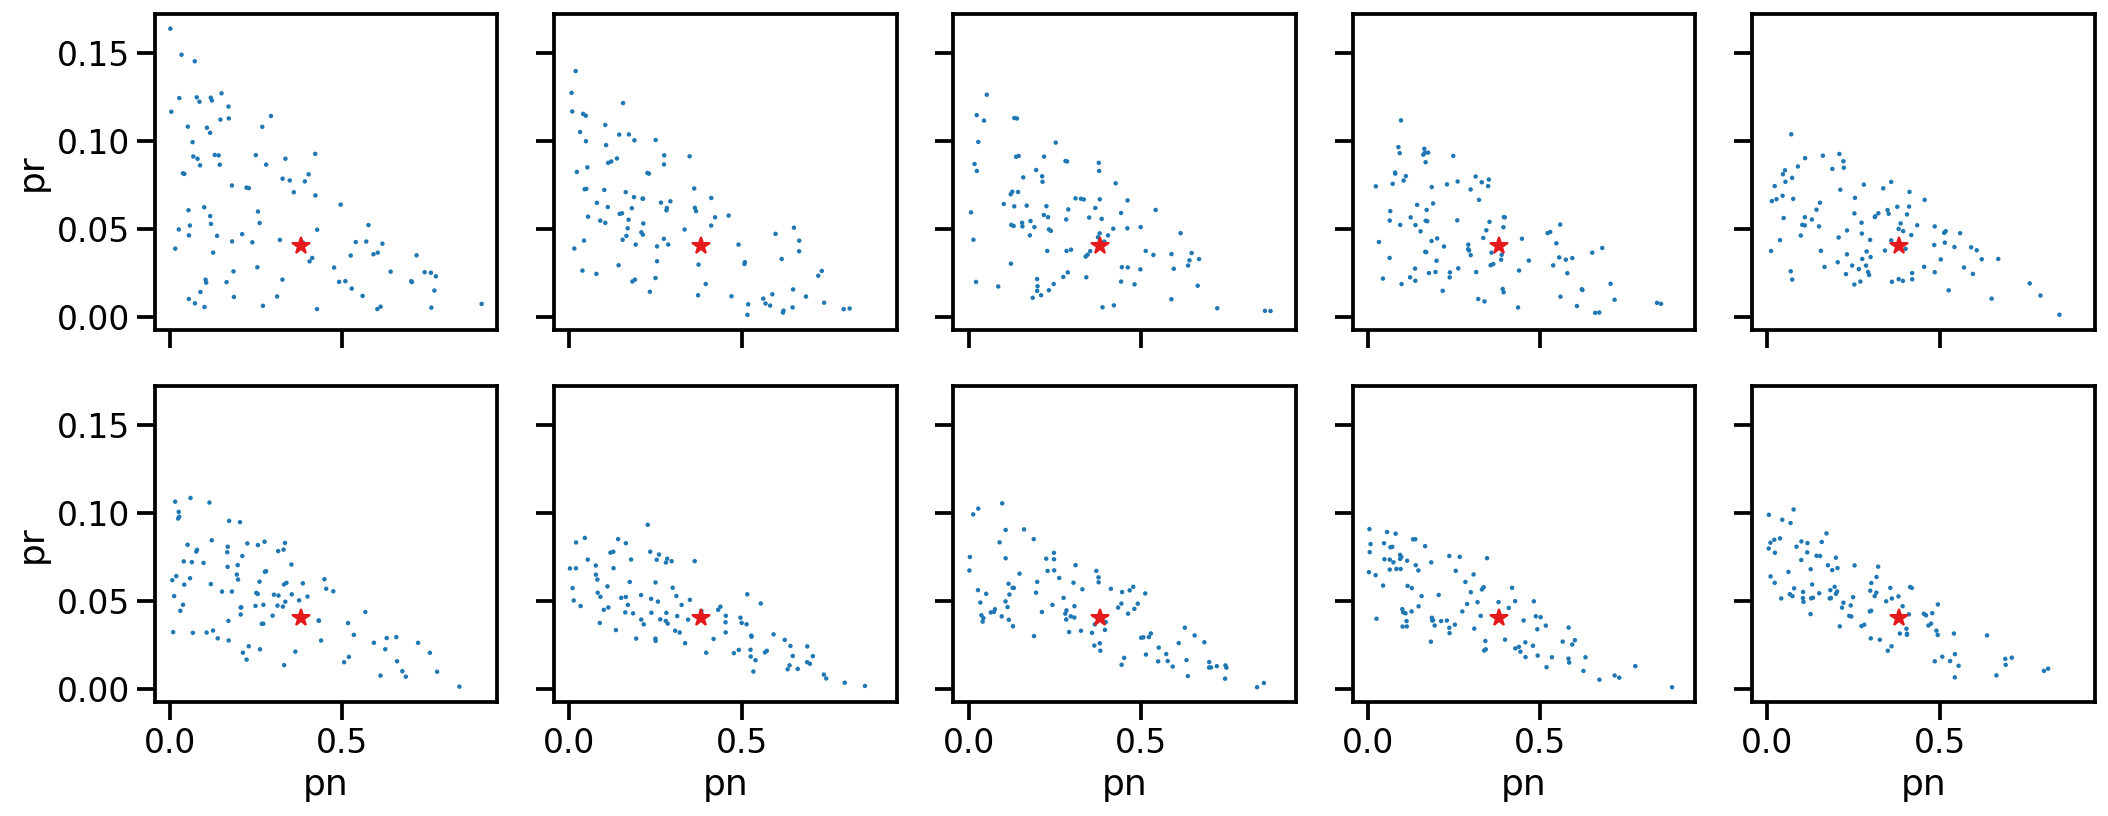

In [191]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
for ax, pop in zip(axes.flat, smc_res.populations):
    s__ = pop.samples
    ax.scatter(s__['pn_'], s__['pr_'], s=5, edgecolor='none')
    ax.plot(pn_hat, pr_hat, '*', color=red)
for ax in axes[1]: ax.set(xlabel='pn')
for ax in axes[:,0]: ax.set(ylabel='pr')
fig.tight_layout()

## Inference with pyABC

Another tool for SMC-ABC is [pyABC](https://pyabc.readthedocs.io/).

In [43]:
import pyabc

In [44]:
priors = pyabc.Distribution(
    pn=pyabc.RV("uniform", 0, 1),
    pr=pyabc.RV("uniform", 0, 1)
)

In [174]:
def model(parameters):
    network = simulator(parameters['pn'], parameters['pr'], batch_size=50)
    return dict(
        mean_degree=mean_degree(network).mean(),
        clustering_coefficient=clustering_coefficient(network).mean()
    )
model({'pn':0.5, 'pr':0.01})

{'mean_degree': 2.9399999999999995,
 'clustering_coefficient': 0.3423530465949821}

In [175]:
def distance(simulation, data):
    return (
        np.abs(data['mean_degree'] - simulation['mean_degree']) +
        np.abs(data['clustering_coefficient'] - simulation['clustering_coefficient'])
    )

observation = dict(
    mean_degree=mean_degree(dolphin_network).squeeze(),
    clustering_coefficient=clustering_coefficient(dolphin_network).squeeze()
)
distance(model({'pn':0.5, 'pr':0.01}), observation)

2.178252365913656

In [47]:
abc = pyabc.ABCSMC(model, 
                   priors, 
                   distance,
                   #population_size=100, # default
                   #eps=MedianEpsilon(), # default
                   sampler=pyabc.SingleCoreSampler())

In [48]:
db_path = ("sqlite://")
abc.new(db_path, observation);

INFO:History:Start <ABCSMC(id=1, start_time=2020-06-02 00:35:16.741539, end_time=None)>


In [49]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=15)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 27.56488443871531
INFO:ABC:t: 0, eps: 27.56488443871531.
INFO:ABC:Acceptance rate: 100 / 185 = 5.4054e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 16.822538560153493.
INFO:ABC:Acceptance rate: 100 / 213 = 4.6948e-01, ESS=7.9568e+01.
INFO:ABC:t: 2, eps: 6.6541367011649655.
INFO:ABC:Acceptance rate: 100 / 278 = 3.5971e-01, ESS=9.1745e+01.
INFO:ABC:t: 3, eps: 2.5602628426112024.
INFO:ABC:Acceptance rate: 100 / 234 = 4.2735e-01, ESS=9.6503e+01.
INFO:ABC:t: 4, eps: 1.2279044642091983.
INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=9.0716e+01.
INFO:ABC:t: 5, eps: 0.6853245770334805.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=9.7362e+01.
INFO:ABC:t: 6, eps: 0.3823915778165265.
INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01, ESS=8.8257e+01.
INFO:ABC:t: 7, eps: 0.2329633219605663.
INFO:ABC:Acceptance rate: 100 / 230 = 4.3478e-01, ESS=9.3662e+01.
INFO:ABC:t: 8, eps: 0.15937758076610745.
INFO:ABC:Acceptance ra

In [186]:
samples, weights = history.get_distribution(m=0)
pn_sample, pr_sample = samples['pn'], samples['pr']
pn_hat, pr_hat = pn_sample.mean(), pr_sample.mean()

print("pn_hat = {:.3f}\npr_hat = {:.3f}".format(pn_hat, pr_hat))

pn_hat = 0.458
pr_hat = 0.033


The posterior distribution plot.

(0.027, 0.037)

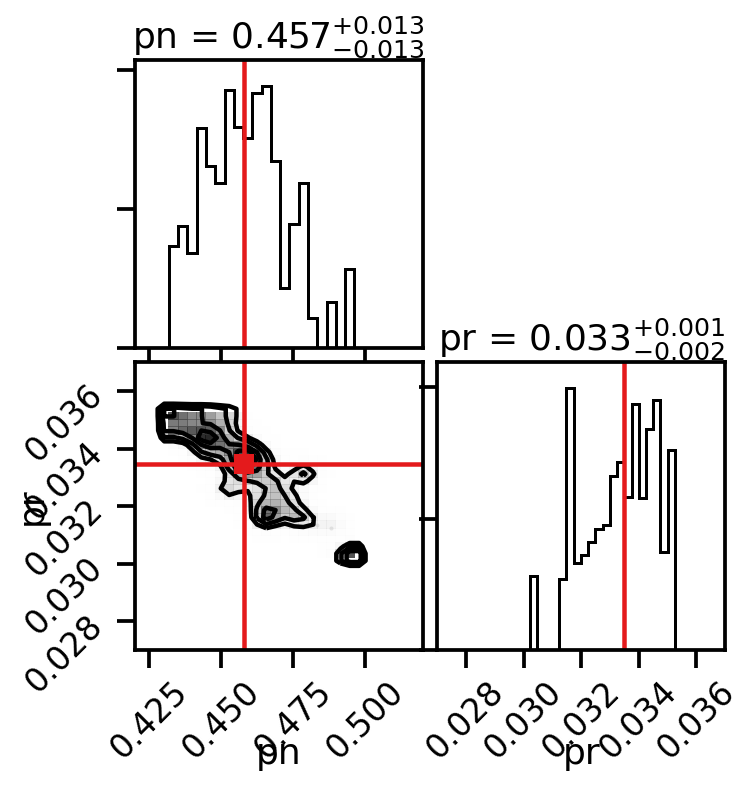

In [170]:
cor = corner(samples, title_fmt='.3f', weights=weights,
    smooth=True,
    show_titles=True,
    truths=(pn_hat, pr_hat),
    truth_color=red,
)
cor.axes[0].set_xlim(0.42, 0.52)
cor.axes[2].set_xlim(0.42, 0.52)
cor.axes[3].set_xlim(0.027, 0.037)
cor.axes[2].set_ylim(0.027, 0.037)

## Posterior distribution convergence

The following shows how the joint posterior converged over the populations of the SMC sampler.

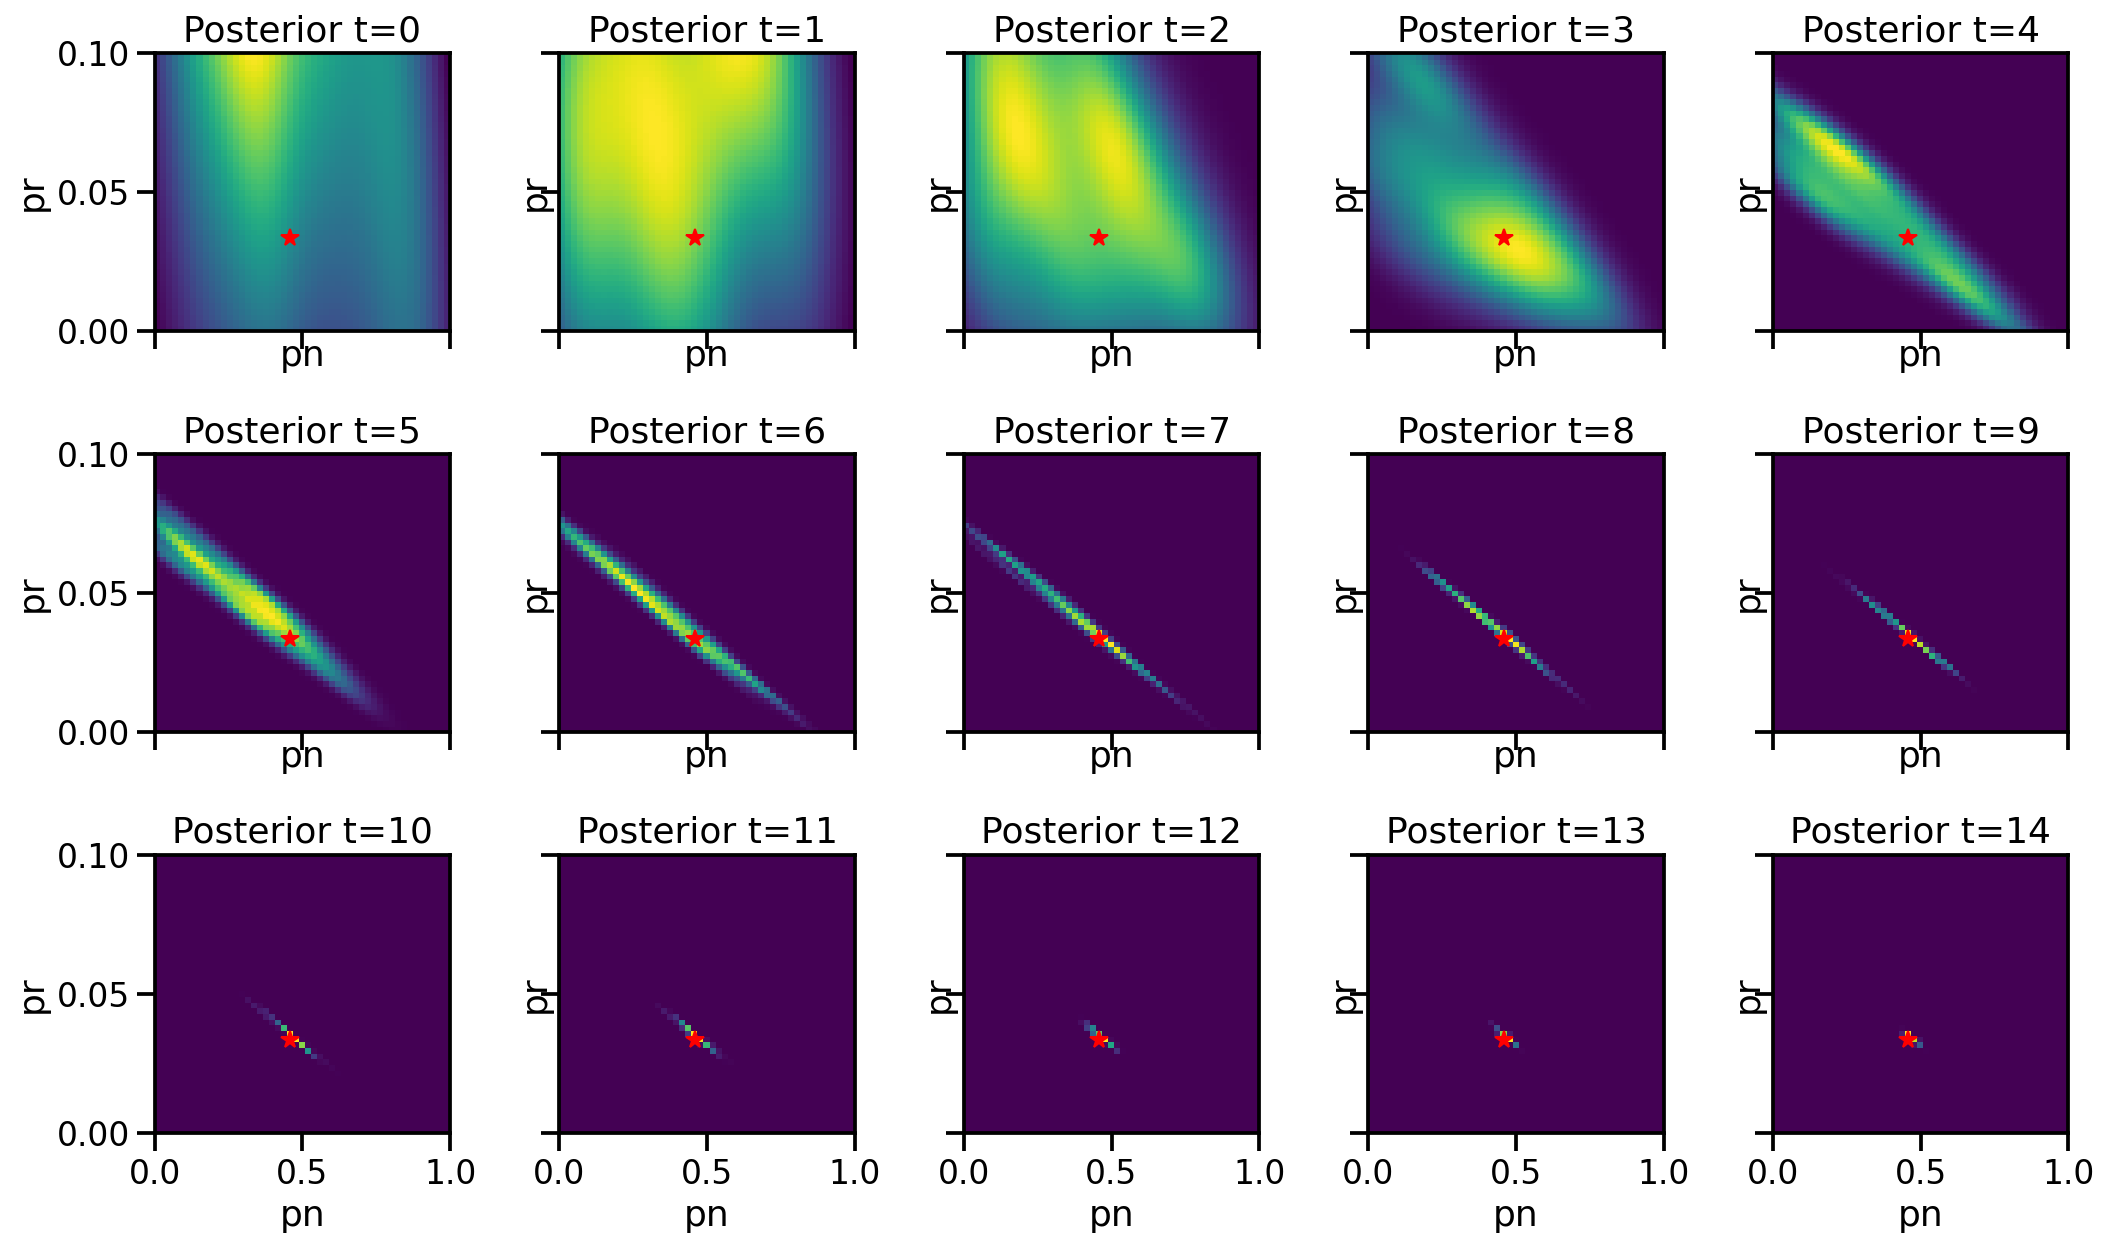

In [166]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)
for t in range(history.max_t + 1):
    ax = axes.flat[t]
    samples_, weights_ = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_2d(
        samples_, weights_, "pn", "pr",
        xmin=0, xmax=1, ymin=0, ymax=0.1, colorbar=False, ax=ax)
    ax.plot(pn_hat, pr_hat, '*', color='red')
    ax.set_title("Posterior t={}".format(t))
ax.set(xticks=[0, 0.5, 1], yticks=[0, 0.05, 0.1])
fig.tight_layout()

## Posterior predictive check

We do a posterior prediction check to see if the posterior predictions for the summary statistics (blue histogram, point estimate in red) are inline with the observations (in black).

The summary statistics using the $p_n$ and $p_r$ estimated using PLS by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084) (see Table 1) are also drawn, in green.

In [85]:
_, sum_stats = history.get_weighted_sum_stats()
sum_stats = np.array([list(stat.values()) for stat in sum_stats]).T

In [177]:
pyabc_summary = sum_stats.mean(axis=1)
print('pyABC: {:.3f}, {:.3f}'.format(*pyabc_summary))

networks = simulator(0.5, 0.28, batch_size=100)
pls_summary = mean_degree(networks).mean(), clustering_coefficient(networks).mean()
print('PLS: {:.3f}, {:.3f}'.format(*pls_summary))

print('Observed: {:.3f}, {:.3f}'.format(*observation.values()))

pyABC: 5.129, 0.259
PLS: 22.827, 0.380
Observed: 5.129, 0.259


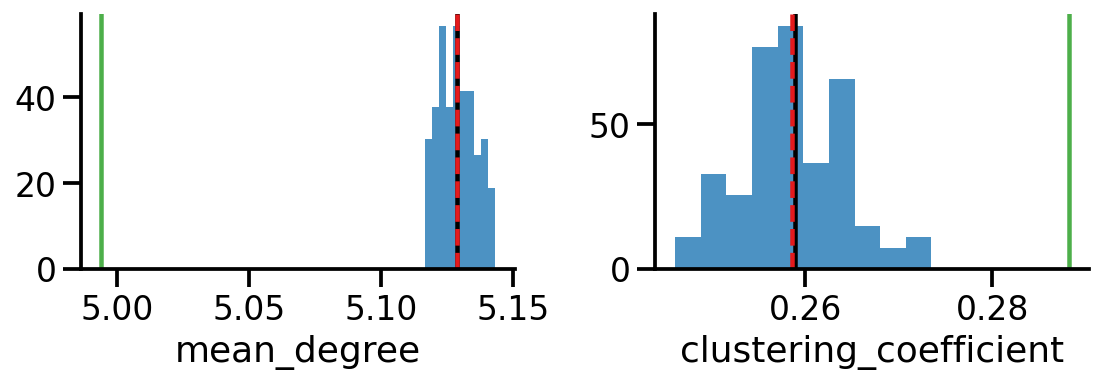

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(sum_stats[0], density=True, alpha=0.8)
axes[0].axvline(observation['mean_degree'], color='k')
axes[0].axvline(pls_summary[0], color=green) # too far
axes[0].axvline(pyabc_summary[0], ls='--', color=red)
axes[0].set(xlabel='mean_degree')

axes[1].hist(sum_stats[1], density=True, alpha=0.8)
axes[1].axvline(observation['clustering_coefficient'], color='k')
axes[1].axvline(pls_summary[1], color=green) # too far
axes[1].axvline(pyabc_summary[1], ls='--', color=red)
axes[1].set(xlabel='clustering_coefficient')

fig.tight_layout()
sns.despine()

# LFI with sbi

In [ ]:
import sbi
import sbi.utils
from sbi.inference.snpe.snpe_c import SnpeC

In [ ]:
def simulation_wrapper(params):
    network = simulator(*params)
#     summstats = torch.as_tensor([mean_degree(network), clustering_coefficient(network)])
    return [mean_degree(network).mean(), clustering_coefficient(network).mean()]

In [ ]:
prior_min = [0, 0]
prior_max = [1, 1]
prior = sbi.utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [ ]:
snpe_common_args = dict(
    simulator=simulation_wrapper,
    x_o=[mean_degree(dolphin_network).squeeze(), clustering_coefficient(dolphin_network).squeeze()],
    prior=prior,
    simulation_batch_size=1,
    num_workers=4,
    worker_batch_size=5,
)

In [ ]:
infer = SnpeC(sample_with_mcmc=False, **snpe_common_args)

# Run inference.
num_rounds, num_simulations_per_round = 1, 100
posterior = infer(
    num_rounds=num_rounds, num_simulations_per_round=num_simulations_per_round, batch_size=10
)

# References

- [Think Bayes, Bayesian Statistics Made Simple](http://greenteapress.com/wp/think-bayes/) by Allen B. Downey
- [Scott Linderman's notes on ABC](https://casmls.github.io/general/2016/10/02/abc.html)
- [Tanaka et al](http://doi.org/10.1534/genetics.106.055574)' paper on ABC-MCMC analysis of Tubercolosis in San Francisco
- [Sisson et al](http://doi.org/10.1073/pnas.0607208104)'s paper on ABC-SMC

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)